In [455]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# For 1 | Preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline # Same, but with the latter it is not necessary to name estimator and transformer
#from imblearn.pipeline import Pipeline as Imb_Pipe
from sklearn.compose import ColumnTransformer

# For 2 | Predictive Modeling: Classification ("occupancy_class")
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.metrics import r2_score, make_scorer, fbeta_score, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import XGBClassifier
import statsmodels.api as sm

# For 3 | Predictive Modeling: Regression ("price")
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor

In [456]:
# Import data_engineered
data = pd.read_pickle("saves/data_engineered.pkl")

In [457]:
# Alternative: Import from csv
#data_types_engineered = pd.read_csv('saves/types_engineered.csv')['types']
#data = pd.read_csv("saves/data_engineered.csv", dtype=data_types_engineered.to_dict())
#data.set_index('id', inplace=True)

In [458]:
# Dashboard
target = 'price'
test_size = 0.3
random_state = 42

In [459]:
#data.zipcode = [str(i) for i in data.zipcode]

# Preprocessing (Train/Test Split and Pipeline)

**Preprocessing pipeline**

In [460]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features = list(data.columns[data.dtypes==object])
#cat_features.remove("zipcode")
cat_features

['cancellation_policy', 'neighbourhood', 'room_type', 'zipcode']

In [461]:
# TEMP: Removing all categorical columns
#data.drop(cat_features, axis=1, inplace=True)
#cat_features = list(data.columns[data.dtypes==object])
#cat_features

In [462]:
# TEMP: Removing all with price >$500
data = data[data.price <= 500]

In [463]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(data.columns[data.dtypes!=object])
num_features.remove(target)
num_features

['accommodates',
 'am_balcony',
 'am_breakfast',
 'am_child_friendly',
 'am_coffee_machine',
 'am_cooking_basics',
 'am_elevator',
 'am_essentials',
 'am_nature_and_views',
 'am_parking',
 'am_pets_allowed',
 'am_private_entrance',
 'am_smoking_allowed',
 'am_tv',
 'am_white_goods',
 'availability_365',
 'bathrooms',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cleaning_fee',
 'extra_people',
 'guests_included',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'house_rules',
 'instant_bookable',
 'is_location_exact',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'monthly_price',
 'occupancy_class',
 'occupancy_rate',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'security_deposit',
 'space',
 'weekly_price']

In [464]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(drop='first', handle_unknown='error'))
])

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [465]:
data.shape

(24399, 50)

In [466]:
data.head(2)

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,room_type,security_deposit,space,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,
3176,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,9.0,9.0,9.0,10.0,9.0,Entire home/apt,1,1,1,zip_10405
3309,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,9.0,9.0,10.0,9.0,9.0,Private room,1,1,1,zip_10777


**Train/test split**

In [467]:
# Define predictors and target variable
X = data.drop([target], axis=1)
y = data[target]

In [468]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True)
#                                                   stratify=y) # Use stratify=y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

In [469]:
# Saving preprocessed X_train and X_test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

**Dummy Classifier (to establish baseline)**

In [470]:
# Set dummy classifier
#dum_clf = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
#y_pred_dum_clf = dum_clf.predict(X_test)

#Distribution of y test
#print('y actual : \n' +  str(y_test_full.value_counts()))

#Distribution of y predicted
#print('y predicted : \n' + str(pd.Series(y_pred_dum_clf).value_counts()))

In [471]:
X_train_prep.shape

(17079, 233)

# Predictive Modeling: Classification ("occupancy_class")

# Predictive Modeling: Regression ("price")

## Linear regression (OLS)

**Apply linear regression**

In [472]:
# Transform X_train_prep and y_train to required format
X_train_prep_ols = X_train_prep.toarray()            # OneHotEncoder outputs csr_matrix, which gives an error when trying to add a constant. Hence, transformed into numpy array
X_train_prep_ols = sm.add_constant(X_train_prep_ols)
y_train_ols = np.asarray(y_train)

In [473]:
# Initiate and fit model
reg_ols = sm.OLS(y_train_ols, X_train_prep_ols).fit()

In [474]:
# Print model summary
reg_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     79.18
Date:                Sat, 18 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:51:19   Log-Likelihood:                -84588.
No. Observations:               17079   AIC:                         1.696e+05
Df Residuals:                   16850   BIC:                         1.714e+05
Df Model:                         228                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.4788      6.115      9.237      0.000      44.493      68.464
x1            14.9503      0.503     29.733      0.000      13.965      15.936
x2             2.0774      0.322      6.442      0.000       1.445       2.710
x3             0.9343      0.269      3.477      0.001       0.408       1.461
x4            -1.7091      0.292     -5.845      0.000      -2.282      -1.136
x5             0.5571      0.377      1.477      0.140      -0.182       1.296
x6             0.1690      0.407      0.415      0.678      -0.629       0.967
x7             3.1003      0.293     10.583      0.000       2.526       3.674
x8             0.0849      0.278      0.306      0.760      -0.460       0.629
x9             0.1391      0.280      0.497      0.619      -0.409       0.687
x10            0.8915      0.324      2.748      0.006       0.256       1.527
x11           -0.0788      0.274     -0.288      0.773      -0.615       0.457
x12            1.8162      0.287      6.323      0.000       1.253       2.379
x13           -1.3762      0.282     -4.881      0.000      -1.929      -0.824
x14            2.2250      0.299      7.433      0.000       1.638       2.812
x15           -0.2117      0.277     -0.764      0.445      -0.755       0.332
x16            5.5617      0.317     17.540      0.000       4.940       6.183
x17            4.1581      0.287     14.506      0.000       3.596       4.720
x18            7.9438      0.372     21.337      0.000       7.214       8.674
x19           -1.5372      0.450     -3.416      0.001      -2.419      -0.655
x20           -1.8457      0.315     -5.852      0.000      -2.464      -1.227
x21           -0.7470      0.384     -1.944      0.052      -1.500       0.006
x22            0.0119      0.302      0.039      0.969      -0.579       0.603
x23            3.7840      0.341     11.111      0.000       3.116       4.452
x24            0.1775      0.275      0.645      0.519      -0.362       0.717
x25            1.8370      0.312      5.883      0.000       1.225       2.449
x26            0.1455      0.337      0.431      0.666      -0.516       0.807
x27           -0.4098      0.288     -1.421      0.155      -0.975       0.156
x28            0.4927      0.280      1.761      0.078      -0.056       1.041
x29            0.1239      0.270      0.459      0.646      -0.405       0.653
x30            0.4355      0.776      0.561      0.575      -1.085       1.956
x31           -1.4980      0.777     -1.929      0.054      -3.021       0.024
x32            1.0965      0.271      4.048      0.000       0.566       1.627
x33           -2.3616      0.273     -8.646      0.000      -2.897      -1.826
x34            0.1560      0.381      0.410      0.682      -0.590       0.902
x35            0.6866      1.711      0.401      0.688      -2.667       4.040
x3

In [475]:
# Predict target (?)

**Apply linear regression w/o preprocessing (to roughly see feature importance)**

In [494]:
# Transform X_train_prep and y_train to required format
X_ols_wo = X.drop(['cancellation_policy', 'neighbourhood', 'room_type', 'zipcode'], axis=1)#.toarray()            # OneHotEncoder outputs csr_matrix, which gives an error when trying to add a constant. Hence, transformed into numpy array
X_ols_wo = sm.add_constant(X_ols_wo)
X_ols_wo = np.asarray(X_ols_wo)
y_ols_wo = np.asarray(y)

In [495]:
type(X_ols_wo)

numpy.ndarray

In [496]:
# Initiate and fit model
reg_ols_wo = sm.OLS(y_ols_wo, X_ols_wo).fit()

In [497]:
# Print model summary
reg_ols_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     402.6
Date:                Sat, 18 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:03:05   Log-Likelihood:            -1.2314e+05
No. Observations:               24399   AIC:                         2.464e+05
Df Residuals:                   24353   BIC:                         2.467e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1104.1907    414.192     -2.666      0.008   -1916.033    -292.349
x1            11.7510      0.280     42.002      0.000      11.203      12.299
x2             4.9728      0.767      6.480      0.000       3.469       6.477
x3             4.2830      1.085      3.947      0.000       2.156       6.410
x4            -1.1309      0.578     -1.955      0.051      -2.265       0.003
x5             1.6398      0.752      2.179      0.029       0.165       3.115
x6             2.0986      0.767      2.735      0.006       0.595       3.602
x7            13.7116      0.601     22.820      0.000      12.534      14.889
x8            -0.1306      0.912     -0.143      0.886      -1.918       1.656
x9            -1.8945      1.566     -1.210      0.226      -4.964       1.175
x10           -2.0042      0.580     -3.454      0.001      -3.142      -0.867
x11           -1.6845      0.666     -2.528      0.011      -2.991      -0.378
x12            9.0185      0.689     13.082      0.000       7.667      10.370
x13           -7.3406      0.657    -11.179      0.000      -8.628      -6.054
x14            7.9658      0.526     15.138      0.000       6.934       8.997
x15           -0.9354      0.691     -1.355      0.176      -2.289       0.418
x16            0.0563      0.003     21.697      0.000       0.051       0.061
x17           10.0492      0.737     13.643      0.000       8.605      11.493
x18           11.0021      0.504     21.833      0.000      10.014      11.990
x19           -2.2217      0.339     -6.559      0.000      -2.886      -1.558
x20           -0.2773      0.056     -4.974      0.000      -0.387      -0.168
x21           -1.5730      0.765     -2.055      0.040      -3.073      -0.073
x22           -0.0449      0.023     -1.924      0.054      -0.091       0.001
x23            6.3346      0.343     18.448      0.000       5.662       7.008
x24            0.3323      0.521      0.638      0.524      -0.689       1.354
x25            5.5860      0.760      7.347      0.000       4.096       7.076
x26           -0.0110      0.007     -1.646      0.100      -0.024       0.002
x27           -0.2097      0.522     -0.402      0.688      -1.233       0.814
x28            1.4682      0.530      2.771      0.006       0.430       2.507
x29            0.4585      0.574      0.799      0.424      -0.666       1.583
x30           21.5861      7.708      2.800      0.005       6.477      36.695
x31           -5.6280      4.106     -1.371      0.170     -13.675       2.419
x32            0.0025      0.000      5.605      0.000       0.002       0.003
x33           -0.0648      0.009     -6.960      0.000      -0.083      -0.047
x34            1.0825      1.221      0.887      0.375      -1.310       3.475
x35            1.2472      0.841      1.483      0.138      -0.401       2.896
x3

## Linear regression (Scikit Learn)

**Apply linear regression**

In [476]:
# Initiate and fit model
reg_lr = LinearRegression()
reg_lr.fit(X_train_prep, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [477]:
# Predict target
y_pred_lr = reg_lr.predict(X_test_prep)

**Final evaluation**

MAE: 21.372572057152503
MSE: 1304.4970239349193
RMSE: 36.117821417340764
R2: 0.4903321409855689


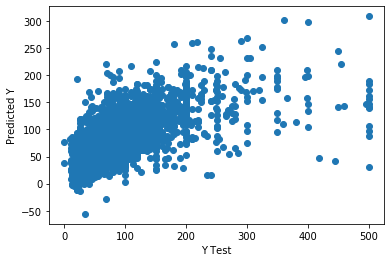

In [479]:
# Plot errors
plt.scatter(y_test, y_pred_lr)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_lr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print('R2:', r2_score(y_test, y_pred_lr))